In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# source the nxcals python libs
from nxcals.api.extraction.data.builders import *
from datetime import datetime
from datetime import timedelta
import pickle
from matplotlib import gridspec
import seaborn as sns
import pickle
from cpymad.madx import Madx
from pybt.tools.plotters import *
from madxtools.plot_tool import *
from madxtools.air_scattering import *
import requests

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 14
    mpl.rcParams['axes.titlesize'] = 20  # Change the number for your preferred fontsize
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [3]:
with open('Quadrupoles_dispersion_run.pickle', 'rb') as f:
    df_quadrupoles = pickle.load(f)

In [4]:
E_cin_per_nucleon = 2.0
# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

print(p/charge)
print(f"gamma = {round(gamma,3)}")
print(f"beta = {round(beta,3)}")
print(f"p = {round(p/charge,3)} GeV/c")

Brho = 3.33564*p/charge

10.706294697042374
gamma = 11.414
beta = 0.996
p = 10.706 GeV/c


In [5]:
selector = "CPS.USER.MD3"
target_timestamp = pd.to_datetime('2023-10-31 18:45:00.00')

keys = ["F61.QFN007/MEAS.PULSE",
           "F61.QDN014/MEAS.PULSE",
           "F61.QFN021/MEAS.PULSE",
           "F61.QDN030/MEAS.PULSE",
           "T08.QFN021/MEAS.PULSE",
           "T08.QDN023/MEAS.PULSE",
           "T08.QDN061/MEAS.PULSE",
           "T08.QFN066/MEAS.PULSE"]

quad_k1_at_targ_t = []
for key in keys:
    print(key)
    df_quadrupoles_key = df_quadrupoles[df_quadrupoles.magnet_name == key]

    differences = (df_quadrupoles_key[df_quadrupoles_key.selector == selector].timestamp - target_timestamp).abs()
    closest_index = differences.idxmin()
    element = closest_index

    print(df_quadrupoles_key.magnet_name.loc[element])
    print(df_quadrupoles_key.timestamp.loc[element])
    print(df_quadrupoles_key.k1.loc[element])
    quad_k1_at_targ_t.append(df_quadrupoles_key.k1.loc[element])
    print("")
print(quad_k1_at_targ_t)

F61.QFN007/MEAS.PULSE
F61.QFN007/MEAS.PULSE
2023-10-28 19:59:15.098238525
0.4795769695381157

F61.QDN014/MEAS.PULSE
F61.QDN014/MEAS.PULSE
2023-10-28 19:59:15.098238525
0.2099947499913021

F61.QFN021/MEAS.PULSE
F61.QFN021/MEAS.PULSE
2023-10-28 19:59:15.098238525
0.19863661203739902

F61.QDN030/MEAS.PULSE
F61.QDN030/MEAS.PULSE
2023-10-28 19:59:15.098238525
0.09034022218415182

T08.QFN021/MEAS.PULSE
T08.QFN021/MEAS.PULSE
2023-10-28 19:59:15.098238525
0.19595168738155916

T08.QDN023/MEAS.PULSE
T08.QDN023/MEAS.PULSE
2023-10-28 19:59:15.098238525
0.19441989147895122

T08.QDN061/MEAS.PULSE
T08.QDN061/MEAS.PULSE
2023-10-28 19:59:15.098238525
0.06140717475213103

T08.QFN066/MEAS.PULSE
T08.QFN066/MEAS.PULSE
2023-10-28 19:59:15.098238525
0.06553821926527045

[0.4795769695381157, 0.2099947499913021, 0.19863661203739902, 0.09034022218415182, 0.19595168738155916, 0.19441989147895122, 0.06140717475213103, 0.06553821926527045]


In [11]:
# Matched initial parameters 13nd oct 2023
betx0 = 53.074
alfx0 = -13.191
Dx0 = 0.13
Dpx0 = 0.02
exn = 2.53e-5

bety0 = 3.675
alfy0 = 0.859
Dy0 = 0.0
Dpy0 = 0.0
eyn = 6.94e-06

sige = 0.0045

# # Matched initial parameters 13nd oct 2023
# betx0 = 6.67479971e+01
# alfx0 = -1.62722259e+01
# Dx0 = 0.08552983
# Dpx0 = 0.01723517
# exn = 2.28304416e-05

# bety0 = 3.76412474e+00
# alfy0 = 7.03346313e-01
# Dy0 = -0.00262435
# Dpy0 = -0.00475684
# eyn = 8.63495536e-06

# sige = 0.0045

ex = exn/(beta*gamma)
ex_initial = ex
ey = eyn/(beta*gamma)
ey_initial = ey

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)

# Quadrupoles
madx.input("kQFN1 = "+str(quad_k1_at_targ_t[0])+";")
madx.input("kQDN2 = "+str(-quad_k1_at_targ_t[1])+";")
madx.input("kQFN3 = "+str(quad_k1_at_targ_t[2])+";")
madx.input("kQDN4 = "+str(-quad_k1_at_targ_t[3])+";")
madx.input("kQFN5 = "+str(quad_k1_at_targ_t[4])+";")
madx.input("kQDN6 = "+str(-quad_k1_at_targ_t[5])+";")
madx.input("kQDN7 = "+str(-quad_k1_at_targ_t[6])+";")
madx.input("kQFN8 = "+str(quad_k1_at_targ_t[7])+";")

# Dipoles
madx.input("kBHZ1 = "+str(-0.04821227494)+";")
madx.input("kBHZ2 = "+str(0.04980753404)+";")
madx.input("kBHZ3 = "+str(0.02555487086)+";")
madx.input("kBHZ4 = "+str(-0.03515967369)+";")
madx.input("kBHZ5 = "+str(-0.03515967369)+";")

# Add the Air region
sequence = "f61t8_op"

p1 = madx.sequence['f61t8_op'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
p2 = madx.sequence['f61t8_op'].elements["f61.btv012"].position
add_air_region(madx, "1", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["f61.bctf022"].position
p2 = madx.sequence['f61t8_op'].elements["f61.mbxhd025"].position + madx.sequence['f61t8_op'].elements["f61.mbxhd025"].length + 0.3
add_air_region(madx, "2", sequence, p1, p2, p2-p1-0.3)

#t08.tbs068, t08.xsec070, t08.xion071, t08.bctf072, t08.bpm073
p1 = madx.sequence['f61t8_op'].elements["t08.tbs068"].position + madx.sequence['f61t8_op'].elements["t08.tbs068"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position
add_air_region(madx, "3", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position + madx.sequence['f61t8_op'].elements["t08.xsec070"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.xion071"].position
add_air_region(madx, "4", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.xion071"].position + madx.sequence['f61t8_op'].elements["t08.xion071"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position
add_air_region(madx, "5", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position + madx.sequence['f61t8_op'].elements["t08.bctf072"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.bpm073"].position
add_air_region(madx, "6", sequence, p1, p2, (p2-p1)/2)

pos_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].position
len_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].length
pos_t08_bpm092 = madx.sequence['f61t8_op'].elements["T08.BPM092"].position
add_air_region(madx, "7", sequence, pos_t08_vac_chamber75 + len_t08_vac_chamber75, pos_t08_bpm092, 1)

pos_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].position
len_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].length
pos_t08_mwpc = madx.sequence['f61t8_op'].elements["T08.xwcm103"].position
add_air_region(madx, "8", sequence, pos_t08_xion094 + len_t08_xion094, pos_t08_mwpc, 1)


# add_hidden_marker(madx, sequence, 20, 100, steps)

madx.command.beam(particle='PROTON',pc=p/charge,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.use(sequence=sequence)

madx.input('''
SEQEDIT, sequence=f61t8_op;
SELECT, FLAG = SEQEDIT, PATTERN = ".*VACC.*";
REMOVE, ELEMENT=SELECTED;
ENDEDIT;
''')

# make thin
madx.use(sequence="f61t8_op")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')
madx.use(sequence="f61t8_op")
madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
# madx.input("MAKETHIN, SEQUENCE=f61t8_op, style=TEAPOT")
madx.use(sequence="f61t8_op")

madx.use(sequence=sequence)
madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
twiss, twiss_scattered = process_scattering(madx, exn, eyn, beta, gamma, sequence, "t08.end", p/charge, twiss, ex_initial, ey_initial)

In [12]:
# # Matched initial parameters 13nd oct 2023
# betx0 = 53.074
# alfx0 = -13.191
# Dx0 = 0.13
# Dpx0 = 0.02
# exn = 2.53e-5

# bety0 = 3.675
# alfy0 = 0.859
# Dy0 = 0.0
# Dpy0 = 0.0
# eyn = 6.94e-06

# sige = 0.0045

# Matched initial parameters 13nd oct 2023
betx0 = 6.67479971e+01
alfx0 = -1.62722259e+01
Dx0 = 0.08552983
Dpx0 = 0.01723517
exn = 2.28304416e-05

bety0 = 3.76412474e+00
alfy0 = 7.03346313e-01
Dy0 = -0.00262435
Dpy0 = -0.00475684
eyn = 8.63495536e-06

sige = 0.0045

ex = exn/(beta*gamma)
ex_initial = ex
ey = eyn/(beta*gamma)
ey_initial = ey

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)

# Quadrupoles
madx.input("kQFN1 = "+str(quad_k1_at_targ_t[0])+";")
madx.input("kQDN2 = "+str(-quad_k1_at_targ_t[1])+";")
madx.input("kQFN3 = "+str(quad_k1_at_targ_t[2])+";")
madx.input("kQDN4 = "+str(-quad_k1_at_targ_t[3])+";")
madx.input("kQFN5 = "+str(quad_k1_at_targ_t[4])+";")
madx.input("kQDN6 = "+str(-quad_k1_at_targ_t[5])+";")
madx.input("kQDN7 = "+str(-quad_k1_at_targ_t[6])+";")
madx.input("kQFN8 = "+str(quad_k1_at_targ_t[7])+";")

# Dipoles
madx.input("kBHZ1 = "+str(-0.04821227494)+";")
madx.input("kBHZ2 = "+str(0.04980753404)+";")
madx.input("kBHZ3 = "+str(0.02555487086)+";")
madx.input("kBHZ4 = "+str(-0.03515967369)+";")
madx.input("kBHZ5 = "+str(-0.03515967369)+";")

# Add the Air region
sequence = "f61t8_op"

p1 = madx.sequence['f61t8_op'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
p2 = madx.sequence['f61t8_op'].elements["f61.btv012"].position
add_air_region(madx, "1", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["f61.bctf022"].position
p2 = madx.sequence['f61t8_op'].elements["f61.mbxhd025"].position + madx.sequence['f61t8_op'].elements["f61.mbxhd025"].length + 0.3
add_air_region(madx, "2", sequence, p1, p2, p2-p1-0.3)

#t08.tbs068, t08.xsec070, t08.xion071, t08.bctf072, t08.bpm073
p1 = madx.sequence['f61t8_op'].elements["t08.tbs068"].position + madx.sequence['f61t8_op'].elements["t08.tbs068"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position
add_air_region(madx, "3", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position + madx.sequence['f61t8_op'].elements["t08.xsec070"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.xion071"].position
add_air_region(madx, "4", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.xion071"].position + madx.sequence['f61t8_op'].elements["t08.xion071"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position
add_air_region(madx, "5", sequence, p1, p2, (p2-p1)/2)

p1 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position + madx.sequence['f61t8_op'].elements["t08.bctf072"].length 
p2 = madx.sequence['f61t8_op'].elements["t08.bpm073"].position
add_air_region(madx, "6", sequence, p1, p2, (p2-p1)/2)

pos_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].position
len_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].length
pos_t08_bpm092 = madx.sequence['f61t8_op'].elements["T08.BPM092"].position
add_air_region(madx, "7", sequence, pos_t08_vac_chamber75 + len_t08_vac_chamber75, pos_t08_bpm092, 1)

pos_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].position
len_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].length
pos_t08_mwpc = madx.sequence['f61t8_op'].elements["T08.xwcm103"].position
add_air_region(madx, "8", sequence, pos_t08_xion094 + len_t08_xion094, pos_t08_mwpc, 1)


# add_hidden_marker(madx, sequence, 20, 100, steps)

madx.command.beam(particle='PROTON',pc=p/charge,exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.use(sequence=sequence)

madx.input('''
SEQEDIT, sequence=f61t8_op;
SELECT, FLAG = SEQEDIT, PATTERN = ".*VACC.*";
REMOVE, ELEMENT=SELECTED;
ENDEDIT;
''')

# make thin
madx.use(sequence="f61t8_op")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')
madx.use(sequence="f61t8_op")
madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
# madx.input("MAKETHIN, SEQUENCE=f61t8_op, style=TEAPOT")
madx.use(sequence="f61t8_op")

madx.use(sequence=sequence)
madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
twiss, twiss_scattered_rematched = process_scattering(madx, exn, eyn, beta, gamma, sequence, "t08.end", p/charge, twiss, ex_initial, ey_initial)

Objective = 0.40952938719412413


(-1.2, 1.2)

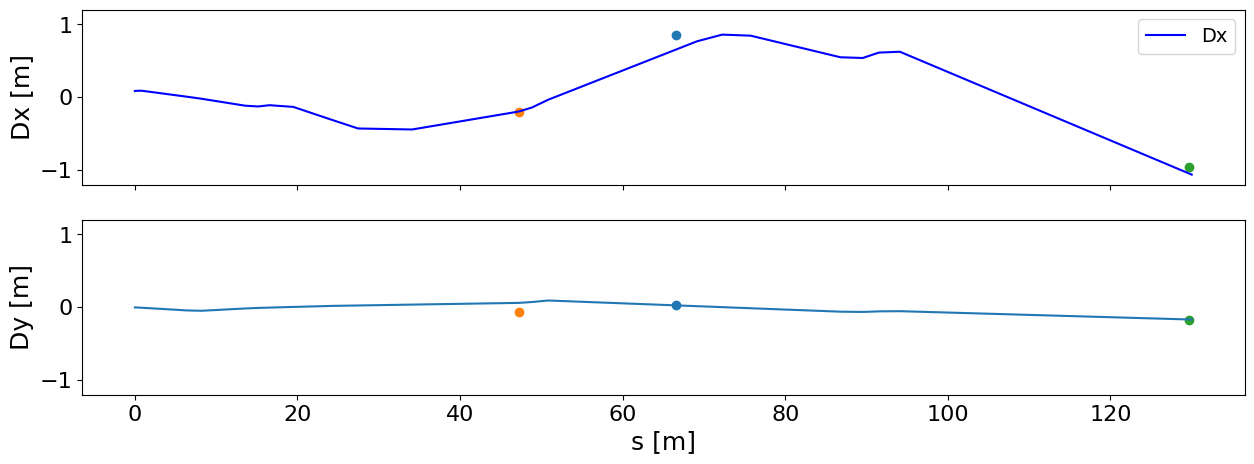

In [9]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(15,5))
ax[0].plot(twiss_scattered.s, twiss_scattered.dx, label='Dx', c="b")

dx_btv035 = 0.851
dx_btv020 = -0.197
dx_xwcm103 = -0.963

dy_btv035 = 0.035
dy_btv020 = -0.061
dy_xwcm103 = -0.169

ax[0].scatter(twiss_scattered.loc['t08.btv035'].s, dx_btv035)
ax[0].scatter(twiss_scattered.loc['t08.btv020'].s, dx_btv020)
ax[0].scatter(twiss_scattered.loc['t08.xwcm103'].s, dx_xwcm103)

ax[1].plot(twiss_scattered.s, twiss_scattered.dy, label='Dy')
ax[1].scatter(twiss_scattered.loc['t08.btv035'].s, dy_btv035)
ax[1].scatter(twiss_scattered.loc['t08.btv020'].s, dy_btv020)
ax[1].scatter(twiss_scattered.loc['t08.xwcm103'].s, dy_xwcm103)

delta_btv035 = np.abs(twiss_scattered.loc['t08.btv035'].dx - dx_btv035)
delta_btv020 = np.abs(twiss_scattered.loc['t08.btv020'].dx - dx_btv020)
delta_xwcm103 = np.abs(twiss_scattered.loc['t08.xwcm103'].dx - dx_xwcm103)

delta_btv035_dy = np.abs(twiss_scattered.loc['t08.btv035'].dy - dy_btv035)
delta_btv020_dy = np.abs(twiss_scattered.loc['t08.btv020'].dy - dy_btv020)
delta_xwcm103_dy = np.abs(twiss_scattered.loc['t08.xwcm103'].dy - dy_xwcm103)

objective = delta_btv035 + delta_btv020 + delta_xwcm103 + delta_btv035_dy + delta_btv020_dy + delta_xwcm103_dy
print(f"Objective = {objective}")


ax[0].legend(loc="upper right")

ax[0].set_ylabel("Dx [m]")
ax[1].set_ylabel("Dy [m]")
ax[1].set_xlabel("s [m]")
ax[0].set_ylim(-1.2,1.2)
ax[1].set_ylim(-1.2,1.2)

In [70]:
import pickle

with open('../../quad-scan-east/dispersion_measurement/dispersion_T8.BTV035.pickle', 'rb') as f:
    df_btv035 = pickle.load(f)

with open('../../quad-scan-east/dispersion_measurement/dispersion_T8.BTV020.pickle', 'rb') as f:
    df_btv020 = pickle.load(f)

with open('../../quad-scan-east/dispersion_measurement/dispersion_mwpc.pickle', 'rb') as f:
    df_mpwc = pickle.load(f)

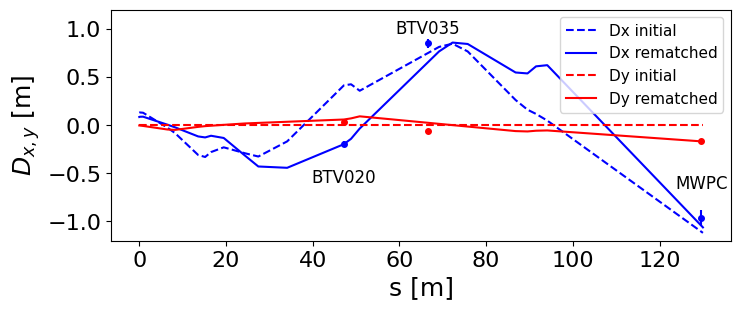

In [75]:
# IPAC 2024 plot
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(twiss_scattered.s, twiss_scattered.dx, c="b", ls="--", label="Dx initial")
ax.plot(twiss_scattered_rematched.s, twiss_scattered_rematched.dx, label='Dx rematched', c="b")

ax.plot(twiss_scattered.s, twiss_scattered.dy,c="r", ls="--", label="Dy initial")
ax.plot(twiss_scattered_rematched.s, twiss_scattered_rematched.dy, label='Dy rematched',c="r")

ax.errorbar(twiss_scattered.loc['t08.btv035'].s, df_btv035.Dispersion[0], yerr=df_btv035.Error[0], c="b", marker="o",ms=4)
ax.errorbar(twiss_scattered.loc['t08.btv035'].s, df_btv035.Dispersion[1], yerr=df_btv035.Error[1], c="r", marker="o", ms=4)
ax.errorbar(twiss_scattered.loc['t08.btv020'].s, df_btv020.Dispersion[0], yerr=df_btv020.Error[0], c="b", marker="o", ms=4)
ax.errorbar(twiss_scattered.loc['t08.btv020'].s, df_btv020.Dispersion[1], yerr=df_btv020.Error[1], c="r", marker="o", ms=4)
ax.errorbar(twiss_scattered.loc['t08.xwcm103'].s, df_mpwc.Dispersion[0], yerr=df_mpwc.Error[0], c="b", marker="o", ms=4)
ax.errorbar(twiss_scattered.loc['t08.xwcm103'].s, df_mpwc.Dispersion[1], yerr=df_mpwc.Error[1], c="r", marker="o", ms=4)

# Adding text annotations for BTV and MWPC
# Adjust the y offsets as needed to place the text boxes at desirable positions
y_offset = 0.1
s_btv035 = twiss_scattered.loc['t08.btv035'].s
s_btv020 = twiss_scattered.loc['t08.btv020'].s
s_xwcm103 = twiss_scattered.loc['t08.xwcm103'].s
ax.text(s_btv035, dx_btv035 + y_offset, f'BTV035', ha='center', fontsize=12)
ax.text(s_btv020, dx_btv020 - 4*y_offset, 'BTV020', ha='center', fontsize=12)
ax.text(s_xwcm103, dx_xwcm103 + 3*y_offset, 'MWPC', ha='center', fontsize=12)

ax.legend(loc="upper right", fontsize=11)

ax.set_ylabel(r"$D_{x,y}$ [m]")
ax.set_ylim(-1.2,1.2)
ax.set_xlabel("s [m]")
plt.savefig("dispersion_diff.png", dpi=300, bbox_inches="tight", transparent=True)

In [18]:
# Optimise

In [26]:
import pybobyqa
iter = 0
def f_fit(params):

    global iter
    print("Iteration: ", iter)
    iter += 1
    print(params)

    dx0, dpx0, dy0, dpy0 = params

    # Matched initial parameters 13nd oct 2023
    betx0 = 53.074
    alfx0 = -13.191
    Dx0 = dx0
    Dpx0 = dpx0
    exn = 2.53e-5

    bety0 = 3.675
    alfy0 = 0.859
    Dy0 = dy0
    Dpy0 = dpy0
    eyn = 6.94e-06

    sige = 0.0045

    ex = exn/(beta*gamma)
    ex_initial = ex
    ey = eyn/(beta*gamma)
    ey_initial = ey

    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
    madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)

    # Quadrupoles
    madx.input("kQFN1 = "+str(quad_k1_at_targ_t[0])+";")
    madx.input("kQDN2 = "+str(-quad_k1_at_targ_t[1])+";")
    madx.input("kQFN3 = "+str(quad_k1_at_targ_t[2])+";")
    madx.input("kQDN4 = "+str(-quad_k1_at_targ_t[3])+";")
    madx.input("kQFN5 = "+str(quad_k1_at_targ_t[4])+";")
    madx.input("kQDN6 = "+str(-quad_k1_at_targ_t[5])+";")
    madx.input("kQDN7 = "+str(-quad_k1_at_targ_t[6])+";")
    madx.input("kQFN8 = "+str(quad_k1_at_targ_t[7])+";")

    # Dipoles
    madx.input("kBHZ1 = "+str(-0.04821227494)+";")
    madx.input("kBHZ2 = "+str(0.04980753404)+";")
    madx.input("kBHZ3 = "+str(0.02555487086)+";")
    madx.input("kBHZ4 = "+str(-0.03515967369)+";")
    madx.input("kBHZ5 = "+str(-0.03515967369)+";")

    # Add the Air region
    sequence = "f61t8_op"

    p1 = madx.sequence['f61t8_op'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
    p2 = madx.sequence['f61t8_op'].elements["f61.btv012"].position
    add_air_region(madx, "1", sequence, p1, p2, (p2-p1)/2)

    p1 = madx.sequence['f61t8_op'].elements["f61.bctf022"].position
    p2 = madx.sequence['f61t8_op'].elements["f61.mbxhd025"].position + madx.sequence['f61t8_op'].elements["f61.mbxhd025"].length + 0.3
    add_air_region(madx, "2", sequence, p1, p2, p2-p1-0.3)

    #t08.tbs068, t08.xsec070, t08.xion071, t08.bctf072, t08.bpm073
    p1 = madx.sequence['f61t8_op'].elements["t08.tbs068"].position + madx.sequence['f61t8_op'].elements["t08.tbs068"].length 
    p2 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position
    add_air_region(madx, "3", sequence, p1, p2, (p2-p1)/2)

    p1 = madx.sequence['f61t8_op'].elements["t08.xsec070"].position + madx.sequence['f61t8_op'].elements["t08.xsec070"].length 
    p2 = madx.sequence['f61t8_op'].elements["t08.xion071"].position
    add_air_region(madx, "4", sequence, p1, p2, (p2-p1)/2)

    p1 = madx.sequence['f61t8_op'].elements["t08.xion071"].position + madx.sequence['f61t8_op'].elements["t08.xion071"].length 
    p2 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position
    add_air_region(madx, "5", sequence, p1, p2, (p2-p1)/2)

    p1 = madx.sequence['f61t8_op'].elements["t08.bctf072"].position + madx.sequence['f61t8_op'].elements["t08.bctf072"].length 
    p2 = madx.sequence['f61t8_op'].elements["t08.bpm073"].position
    add_air_region(madx, "6", sequence, p1, p2, (p2-p1)/2)

    pos_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].position
    len_t08_vac_chamber75 = madx.sequence['f61t8_op'].elements["T08.VACCUM_CHAMBER75"].length
    pos_t08_bpm092 = madx.sequence['f61t8_op'].elements["T08.BPM092"].position
    add_air_region(madx, "7", sequence, pos_t08_vac_chamber75 + len_t08_vac_chamber75, pos_t08_bpm092, 1)

    pos_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].position
    len_t08_xion094 = madx.sequence['f61t8_op'].elements["T08.xion094"].length
    pos_t08_mwpc = madx.sequence['f61t8_op'].elements["T08.xwcm103"].position
    add_air_region(madx, "8", sequence, pos_t08_xion094 + len_t08_xion094, pos_t08_mwpc, 1)


    # add_hidden_marker(madx, sequence, 20, 100, steps)

    madx.command.beam(particle='PROTON',pc=p/charge,exn=exn,eyn=eyn)
    madx.input('BRHO      := BEAM->PC * 3.3356;')
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
    madx.use(sequence=sequence)

    madx.input('''
    SEQEDIT, sequence=f61t8_op;
    SELECT, FLAG = SEQEDIT, PATTERN = ".*VACC.*";
    REMOVE, ELEMENT=SELECTED;
    ENDEDIT;
    ''')

    # make thin
    madx.use(sequence="f61t8_op")
    madx.input('SEQEDIT, sequence=f61t8_op;')
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence="f61t8_op")
    madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
    # madx.input("MAKETHIN, SEQUENCE=f61t8_op, style=TEAPOT")
    madx.use(sequence="f61t8_op")

    madx.use(sequence=sequence)
    madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
    twiss, twiss_scattered = process_scattering(madx, exn, eyn, beta, gamma, sequence, "t08.end", p/charge, twiss, ex_initial, ey_initial)

    dx_btv035 = 0.851
    dx_btv020 = -0.197
    dx_xwcm103 = -0.963

    dy_btv035 = 0.035
    dy_btv020 = -0.061
    dy_xwcm103 = -0.169

    delta_btv035 = np.abs(twiss_scattered.loc['t08.btv035'].dx - dx_btv035)
    delta_btv020 = np.abs(twiss_scattered.loc['t08.btv020'].dx - dx_btv020)
    delta_xwcm103 = np.abs(twiss_scattered.loc['t08.xwcm103'].dx - dx_xwcm103)

    delta_btv035_dy = np.abs(twiss_scattered.loc['t08.btv035'].dy - dy_btv035)
    delta_btv020_dy = np.abs(twiss_scattered.loc['t08.btv020'].dy - dy_btv020)
    delta_xwcm103_dy = np.abs(twiss_scattered.loc['t08.xwcm103'].dy - dy_xwcm103)

    objective = delta_btv035 + delta_btv020 + delta_xwcm103 + delta_btv035_dy + delta_btv020_dy + delta_xwcm103_dy

    print(objective)
    print("")

    return objective


initial_guess = [0.13, 0.02, 0.0, 0.0]

lower = np.array([-1, -1, -1, -1])
upper = np.array([1, 1, 1, 1])

# Open the file in write mode, which will erase its contents
with open('progress.csv', 'w') as file:
    pass  # This line does nothing, but it ensures the file is opened and immediately closed
# The contents of 'progress.csv' are now erased

# Call Py-BOBYQA
soln = pybobyqa.solve(f_fit, initial_guess, bounds=(lower, upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=False, scaling_within_bounds=True, rhoend=1e-5, maxfun=500)

# Display output
print(soln)

Iteration:  0
[0.13 0.02 0.   0.  ]
1.120973932971283

Iteration:  1
[1.   0.02 0.   0.  ]
20.9579779722387

Iteration:  2
[0.13 1.   0.   0.  ]
90.481661978699

Iteration:  3
[0.13 0.02 1.   0.  ]
33.31284253085252

Iteration:  4
[0.13 0.02 0.   1.  ]
36.217878704311005

Iteration:  5
[-0.87  0.02  0.    0.  ]
22.6424209791573

Iteration:  6
[ 0.13 -0.98  0.    0.  ]
93.64593905189543

Iteration:  7
[ 0.13  0.02 -1.    0.  ]
33.02684253085252

Iteration:  8
[ 0.13  0.02  0.   -1.  ]
35.931878704311

Iteration:  9
[ 0.08400208  0.01861218 -0.00223097 -0.00204555]
0.608848715649623

Iteration:  10
[-0.10047106  0.01858534 -0.00227406 -0.00208507]
4.71009074672879

Iteration:  11
[ 0.08041173  0.0186124   0.0899357  -0.00204522]
3.466825761986002

Iteration:  12
[ 0.07172907  0.0186117  -0.09364737 -0.00204588]
3.614432447304552

Iteration:  13
[ 0.08235426  0.01861229 -0.00216152  0.04404324]
2.07603188525699

Iteration:  14
[ 0.07864923  0.01861143 -0.00081733 -0.04783032]
2.0919853108

In [27]:
print(soln.x)

[ 0.08552983  0.01723517 -0.00262435 -0.00475684]
